In [1]:
import os
import numpy as np
import pickle

### SELECT DATA
#from config import MRI8_NVF4_10mm_0p0mmVVVV as cfg

os.chdir('../')
from lib.methods import *
from lib.functions import *

fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })

2023-05-02 01:18:44.488733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.chdir('../')

In [3]:
class MRI8_NVF4_10mm_0p0mmVVVV:
    CSV_FILE_DIR = './data/VF_FVF_DATASETS/CSV/'
    VIDEO_FILE_DIR = './data/VF_FVF_DATASETS/VIDEO/'
    DATA_NAME = 'MRI8_NVF4_10mm_0p0mmVVVV'
    CSV_ADDITIONAL_PATH = ''
    SAMPLE_SPAN = [40000, 140000]
    LINE_SCANNING_PARAMS_VF = {'position':[50, 40],'width': 40}
    LINE_SCANNING_PARAMS_FVF = {'position':[70, 80],'width': 70}
    FILTERING_VIDEO_PARAMS_VF = {'kernel_length':10, 'kernel_size':3}
    FILTERING_VIDEO_PARAMS_FVF = {'kernel_length':10, 'kernel_size':3}
    AUTOENCODER_METHOD = 'MLP'
    AUTOENCODER_PARAMS_VF = { 'hidden_layers_shape': [20],
                            'latent_dim': 1,
                            'latent_regularizer': None,
                            'random_state': 0,
                            'learning_rate': 1e-3,
                            'loss_function': 'mse',
                            'epochs': 300,
                            'batch_size': 1024,
                            'verbose': 0,
                            'callbacks': None }
    AUTOENCODER_PARAMS_FVF = { 'hidden_layers_shape': [35],
                            'latent_dim': 1,
                            'latent_regularizer': None,
                            'random_state': 0,
                            'learning_rate': 1e-3,
                            'loss_function': 'mse',
                            'epochs': 300,
                            'batch_size': 1024,
                            'verbose': 0,
                            'callbacks': None }
    BF_CONVERT_PARAMS = { 'parameter_sample_step': 1000,'standardize': True, 'mean0':False }
    BF_DISCRETIZATION_PARAMS_VF = { 'upside_down': True,'prominence': 1 }
    BF_DISCRETIZATION_PARAMS_FVF = { 'upside_down': False,'prominence': 0.1 }
    SINDY_PARAM_LIM = (55, 90)
    SINDY_TRAIN_N_SAMPLE_VF = 6
    SINDY_TRAIN_PARAMS_LIST_VF = [0, 1, 2, 3, 4, 5,  6,  8, 9, 10, 11,  12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,    26, 27, 28,     30, 31, 32, 33, 34]
    SINDY_PARAMS_VF = {'order':7, 'threshold':0.1, 'alpha':1e-1, }
    SINDY_FREERUN_PARAMS_VF = {'data0':1.5, 'parameter_start_stop_step':(0.75, 1.001, 0.0001), 'n_run':10, 'n_idling_run':10}
    SINDY_TRAIN_N_SAMPLE_FVF = 15
    SINDY_TRAIN_PARAMS_LIST_FVF = [0,   5,   10, 11, 12, 13, 14,   15, 16, 17,   19,   22, 21, 23, 24, 25,   27, 28, 29,    34]
    SINDY_PARAMS_FVF = {'order':7, 'threshold':0.1, 'alpha':1e-1, }
    SINDY_FREERUN_PARAMS_FVF = {'data0':1.0, 'parameter_start_stop_step':(0.75, 1.001, 0.0001), 'n_run':10, 'n_idling_run':10}
    LV_DIR = './results/lv_of_video/'
    SINDY_MODEL_DIR = './results/sindy_model/'

cfg = MRI8_NVF4_10mm_0p0mmVVVV

In [15]:
csv_data_list, video_data_list, video_t_data_list = LoadCSVandVIDEOS(
                                                                    csv_path=cfg.CSV_FILE_DIR+cfg.DATA_NAME+cfg.CSV_ADDITIONAL_PATH+'.csv', 
                                                                    data_name_list=['t', 'mic', 'flow'], 
                                                                    sample_span=cfg.SAMPLE_SPAN, 
                                                                    videos_path_list=[
                                                                                    cfg.VIDEO_FILE_DIR+'VF/'+cfg.DATA_NAME+'.avi',
                                                                                    cfg.VIDEO_FILE_DIR+'FVF/'+cfg.DATA_NAME+'.avi',
                                                                                    ]
                                                                    )

Loading csv data
file path | ./data/VF_FVF_DATASETS/CSV/MRI8_NVF4_10mm_0p0mmVVVV.csv
data list | t, mic, flow
Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/VF/MRI8_NVF4_10mm_0p0mmVVVV.avi


Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/FVF/MRI8_NVF4_10mm_0p0mmVVVV.avi


In [16]:
pp = PreProcessing(
                data=csv_data_list[1], ### mic data
                t_data=csv_data_list[0], ### mic t data
                video_data_list=video_data_list, 
                video_t_data_list=video_t_data_list
                )
pp.filter()
pp.linescanning_video(params_list=[cfg.LINE_SCANNING_PARAMS_VF, cfg.LINE_SCANNING_PARAMS_FVF])

mic_data = pp.data
mic_t_data = pp.t_data
video_data_list = pp.video_data_list
video_t_list = pp.video_t_data_list

flow_data = csv_data_list[2]
video_vf_data = video_data_list[0]
video_fvf_data = video_data_list[1]
video_t_data = video_t_data_list[0]

In [6]:
### LOAD
latent_vector_vf = pickle.load(open(cfg.LV_DIR+cfg.DATA_NAME+'_vf.pkl', 'rb'))
latent_vector_fvf = pickle.load(open(cfg.LV_DIR+cfg.DATA_NAME+'_fvf.pkl', 'rb'))

In [26]:
### BIFURCATION CONVERT
BC_vf = BifurcationConvert(data=latent_vector_vf, parameter_data=flow_data, t_data=video_t_data)
BC_vf.convert(params = cfg.BF_CONVERT_PARAMS)
BC_vf.discretization(params = cfg.BF_DISCRETIZATION_PARAMS_VF)

param_lim = cfg.SINDY_PARAM_LIM
bifurcation_parameter_vf_list = BC_vf.bifurcation_parameter_list[param_lim[0]:param_lim[-1]]
bifurcation_data_vf_list = BC_vf.bifurcation_data_list[param_lim[0]:param_lim[-1]]
bifurcation_t_data_vf_list = BC_vf.bifurcation_t_data_list[param_lim[0]:param_lim[-1]]
bifurcation_data_vf_list_discreted = BC_vf.bifurcation_data_list_discreted[param_lim[0]:param_lim[-1]]
bifurcation_data_vf_list_discreted_index = BC_vf.bifurcation_data_list_discreted_index[param_lim[0]:param_lim[-1]]

In [33]:
### BIFURCATION CONVERT (VIDEO)
BC_vf = BifurcationConvert(data=video_vf_data, parameter_data=flow_data, t_data=video_t_data)
BC_vf.convert(params={ 'parameter_sample_step': 1000,'standardize': False, 'mean0':False })

bifurcation_video_data_vf_list = BC_vf.bifurcation_data_list[param_lim[0]:param_lim[-1]]

In [97]:
import matplotlib.pylab as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

class Figure():

    def __init__(self, rcParams_dict):
        for key in rcParams_dict.keys():
            plt.rcParams[str(key)] = rcParams_dict[str(key)]   

    def plt_esn_results(self, 
                scanned_video, latent_vector, latent_vector_discreted, latent_vector_discreted_idx, t, bifurcation_data, bifurcation_params,
                conversion_param=40.,
                figsize=(25, 5), width_ratios=[1, 1], wspace=0.5, height_ratios=[1, 1], hspace=0.5,
                title1=None, title2=None, title3=None,
                aspect=0.9, gamma=0.3,
                lw_lv=3, c_lv='k', label_lv='Latent vector',
                marker_lv_lm='o', s_lv_lm=10, c_lv_lm='b', label_lv_lm='Local maxima', legend=False,
                xlim=(None, None), ylim=(None, None), xlabel=r'$mu $'+'[l/min]', ylabel=r'$y_l$', marker='.', c='b', s=50,
                panel_list = ['(a)', '(b)', '(c)'], panel_xy_list=[(0.17, 1.05), (0.27, 1.05), (0.31, 1.05)], panel_fontsize=40, 
                save_filename=None):
        spec = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=width_ratios, wspace=wspace, height_ratios=height_ratios, hspace=hspace)
        fig = plt.figure(figsize=figsize)

        scanned_video = gamma_correction(scanned_video, gamma)

        ax1 = fig.add_subplot(spec[0, 0])
        ax1.set_title(title1, loc='left')
        ax1.imshow(scanned_video.T, cmap='Greys_r', norm=Normalize(vmin=0, vmax=255), aspect=aspect)
        ax1.tick_params(labelleft=False, left=False, labelbottom=False, bottom=True)
        fig.text(ax1.get_position().x1-panel_xy_list[0][0], ax1.get_position().y1-panel_xy_list[0][1], s=panel_list[0], fontsize=panel_fontsize)

        ax2 = fig.add_subplot(spec[1 ,0], xmargin=0)
        ax2.set_title(title2, loc='left')
        ax2.plot((t-t[0])*1000, latent_vector, lw=lw_lv, c=c_lv, label=label_lv)
        ax2.plot(((t-t[0])[latent_vector_discreted_idx])*1000, latent_vector_discreted, linestyle='None', lw=0, c=c_lv_lm, marker=marker_lv_lm, markersize=s_lv_lm, label=label_lv_lm)
        ax2.set_xlabel('Time [ms]')
        #ax2.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%2f'))
        #ax2.get_yaxis().set_major_formatter(plt.FormatStrFormatter('%.2f'))
        ax2.tick_params(labelleft=False, left=False, labelbottom=True, bottom=True)
        if legend:
            ax2.legend(frameon=False)
        fig.text(ax2.get_position().x1-panel_xy_list[1][0], ax2.get_position().y1-panel_xy_list[1][1], s=panel_list[1], fontsize=panel_fontsize)

        ax3 = fig.add_subplot(spec[0:, 1])
        ax3.set_title(title3, loc='left')
        for i in range(len(bifurcation_data)):  
            ax3.scatter(np.full(bifurcation_data[i].shape, bifurcation_params[i]*conversion_param), bifurcation_data[i], marker=marker, c=c, s=s)
        ax3.tick_params(labelleft=False, left=False, labelbottom=True, bottom=True)
        ax3.set_xlim(xlim)
        ax3.set_ylim(ylim)
        ax3.set_xlabel(xlabel)
        ax3.set_ylabel(ylabel)
        fig.text(ax3.get_position().x1-panel_xy_list[2][0], ax3.get_position().y1-panel_xy_list[2][1], s=panel_list[2], fontsize=panel_fontsize)

        plt.tight_layout()
        if save_filename==None:
            plt.show()
        else:
            plt.savefig(save_filename, bbox_inches="tight")

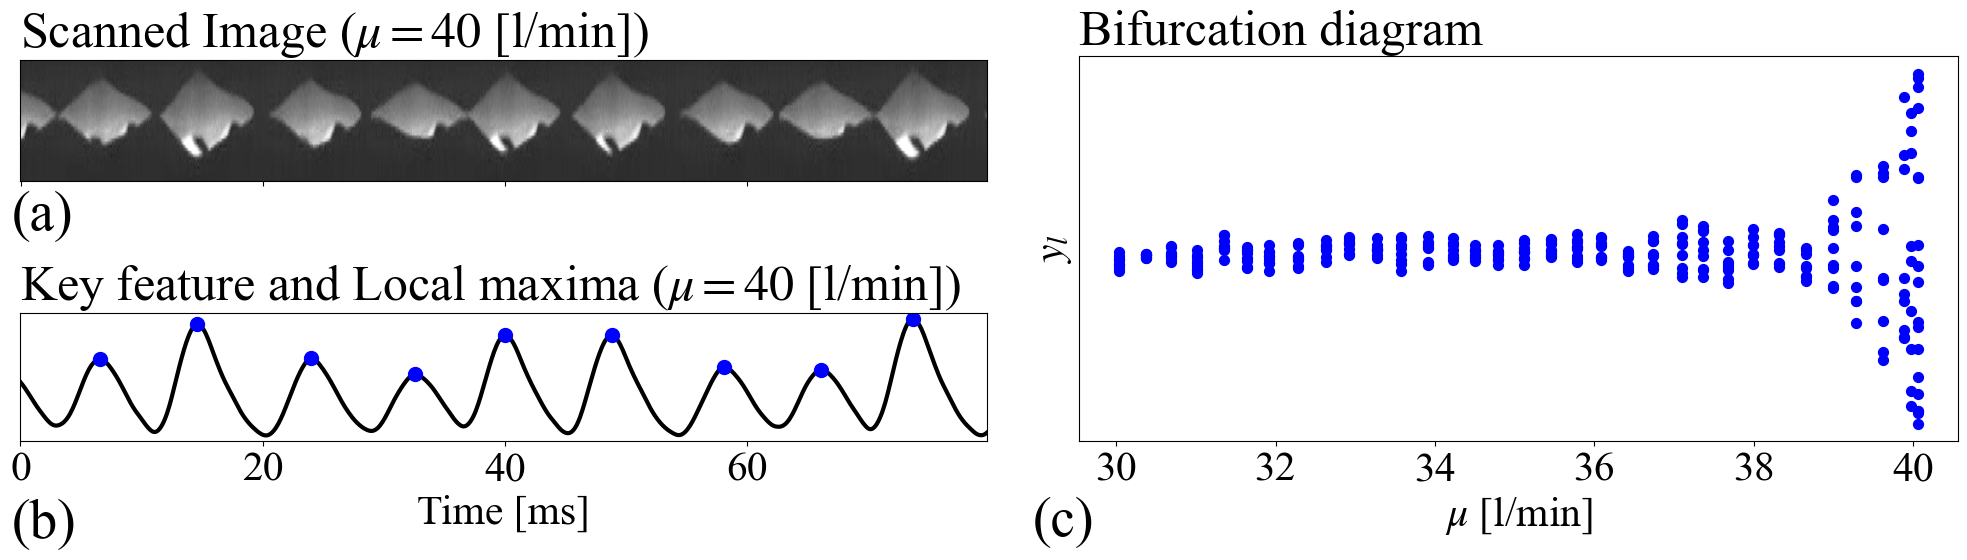

In [118]:
fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })

param_num = -2

fig.plt_esn_results(
                bifurcation_video_data_vf_list[param_num], 
                bifurcation_data_vf_list[param_num], bifurcation_data_vf_list_discreted[param_num], bifurcation_data_vf_list_discreted_index[param_num], bifurcation_t_data_vf_list[param_num], 
                bifurcation_data_vf_list_discreted, bifurcation_parameter_vf_list,
                figsize=(25, 5), width_ratios=[1.1, 1], wspace=0.1, height_ratios=[1, 1], hspace=1,
                title1='Scanned Image ('+r'$\mu=40$'+' [l/min])', title2='Key feature and Local maxima ('+r'$\mu=40$'+' [l/min])', title3='Bifurcation diagram',
                aspect=2.5, gamma=1,
                lw_lv=3, c_lv='k', label_lv='Latent vector',
                marker_lv_lm='o', s_lv_lm=10, c_lv_lm='b', label_lv_lm='Local maxima', 
                xlim=(None, None), ylim=(None, None), xlabel=r'$\mu $'+' [l/min]', ylabel=r'$y_l$', marker='.', c='b', s=200,
                panel_list = ['(a)', '(b)', '(c)'], panel_xy_list=[(0.39, 0.34), (0.39, 0.45), (0.37, 0.96)], panel_fontsize=40, 
                save_filename=None)

In [111]:
bifurcation_parameter_vf_list[param_num]

1.0014747619628905

In [119]:
### BIFURCATION CONVERT
BC_fvf = BifurcationConvert(data=latent_vector_fvf, parameter_data=flow_data, t_data=video_t_data)
BC_fvf.convert(params = cfg.BF_CONVERT_PARAMS)
BC_fvf.discretization(params = cfg.BF_DISCRETIZATION_PARAMS_FVF)

param_lim = cfg.SINDY_PARAM_LIM
bifurcation_parameter_fvf_list = BC_fvf.bifurcation_parameter_list[param_lim[0]:param_lim[-1]]
bifurcation_data_fvf_list = BC_fvf.bifurcation_data_list[param_lim[0]:param_lim[-1]]
bifurcation_t_data_fvf_list = BC_fvf.bifurcation_t_data_list[param_lim[0]:param_lim[-1]]
bifurcation_data_fvf_list_discreted = BC_fvf.bifurcation_data_list_discreted[param_lim[0]:param_lim[-1]]
bifurcation_data_fvf_list_discreted_index = BC_fvf.bifurcation_data_list_discreted_index[param_lim[0]:param_lim[-1]]

In [120]:
### BIFURCATION CONVERT (VIDEO)
BC_fvf = BifurcationConvert(data=video_fvf_data, parameter_data=flow_data, t_data=video_t_data)
BC_fvf.convert(params={ 'parameter_sample_step': 1000,'standardize': False, 'mean0':False })

bifurcation_video_data_fvf_list = BC_fvf.bifurcation_data_list[param_lim[0]:param_lim[-1]]

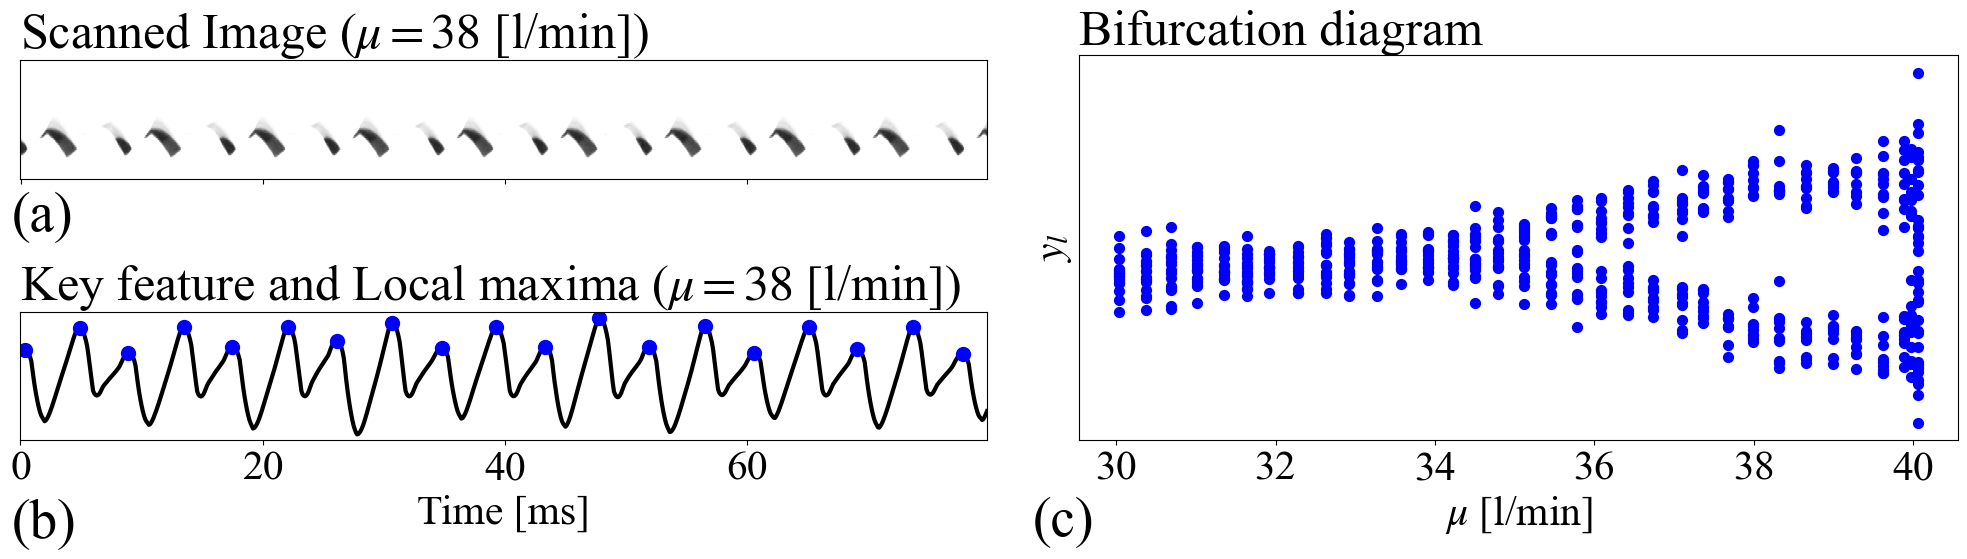

In [133]:
fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })

param_num = -9

fig.plt_esn_results(
                bifurcation_video_data_fvf_list[param_num], 
                bifurcation_data_fvf_list[param_num], bifurcation_data_fvf_list_discreted[param_num], bifurcation_data_fvf_list_discreted_index[param_num], bifurcation_t_data_fvf_list[param_num], 
                bifurcation_data_fvf_list_discreted, bifurcation_parameter_fvf_list,
                figsize=(25, 5), width_ratios=[1.1, 1], wspace=0.1, height_ratios=[1, 1], hspace=1,
                title1='Scanned Image ('+r'$\mu=38$'+' [l/min])', title2='Key feature and Local maxima ('+r'$\mu=38$'+' [l/min])', title3='Bifurcation diagram',
                aspect=1.4, gamma=1,
                lw_lv=3, c_lv='k', label_lv='Latent vector',
                marker_lv_lm='o', s_lv_lm=10, c_lv_lm='b', label_lv_lm='Local maxima', 
                xlim=(None, None), ylim=(None, None), xlabel=r'$\mu $'+' [l/min]', ylabel=r'$y_l$', marker='.', c='b', s=200,
                panel_list = ['(a)', '(b)', '(c)'], panel_xy_list=[(0.39, 0.34), (0.39, 0.45), (0.37, 0.96)], panel_fontsize=40, 
                save_filename=None)

In [132]:
bifurcation_parameter_fvf_list[param_num]*40

38.317266845703124